<a href="https://colab.research.google.com/github/architagarwal21/streamlitapp/blob/main/Team2_final_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing Libraries
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Dropout , BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers,models,Model
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print(tf.__version__)

import pandas as pd
import numpy as np
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import os
import glob

2.15.0


In [ ]:
# Adding plots in notebook
%matplotlib inline
np.set_printoptions(precision=3, suppress=True)

In [ ]:
# Function to count the number of images per category and display a sample
def plot_images(image_dirs):
    if len(image_dirs) == 1:
        fig, axes = plt.subplots(1, 4, figsize=(15, 4))
    else:
        fig, axes = plt.subplots(len(image_dirs), 4, figsize=(15, len(image_dirs)*4))

    for i, image_dir in enumerate(image_dirs):
        images = os.listdir(image_dir)
        num_images = len(images)
        if num_images == 0:
            print(f"No images found in directory: {image_dir}")
            continue

        for j, image_name in enumerate(images[:4]):  # Limiting to 4 images per class for visualization
            img_path = os.path.join(image_dir, image_name)
            image = cv2.imread(img_path)
            if image is None:
                print(f"Failed to read image: {img_path}")
                continue
            if len(image_dirs) == 1:
                axes[j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[j].set_title(image_name)
                axes[j].axis('off')
            else:
                axes[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
                axes[i, j].set_title(image_name)
                axes[i, j].axis('off')
        print(num_images)
    plt.tight_layout()
    plt.show()

In [ ]:
# Importing images from Kaggle
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

import kaggle
kaggle.api.authenticate()

Saving kaggle.json to kaggle.json


In [ ]:
! kaggle datasets download msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 98% 59.0M/60.3M [00:00<00:00, 172MB/s]
100% 60.3M/60.3M [00:00<00:00, 148MB/s]


In [ ]:
!unzip fer2013.zip

3995
436
4097
7215
4965
4830
3171


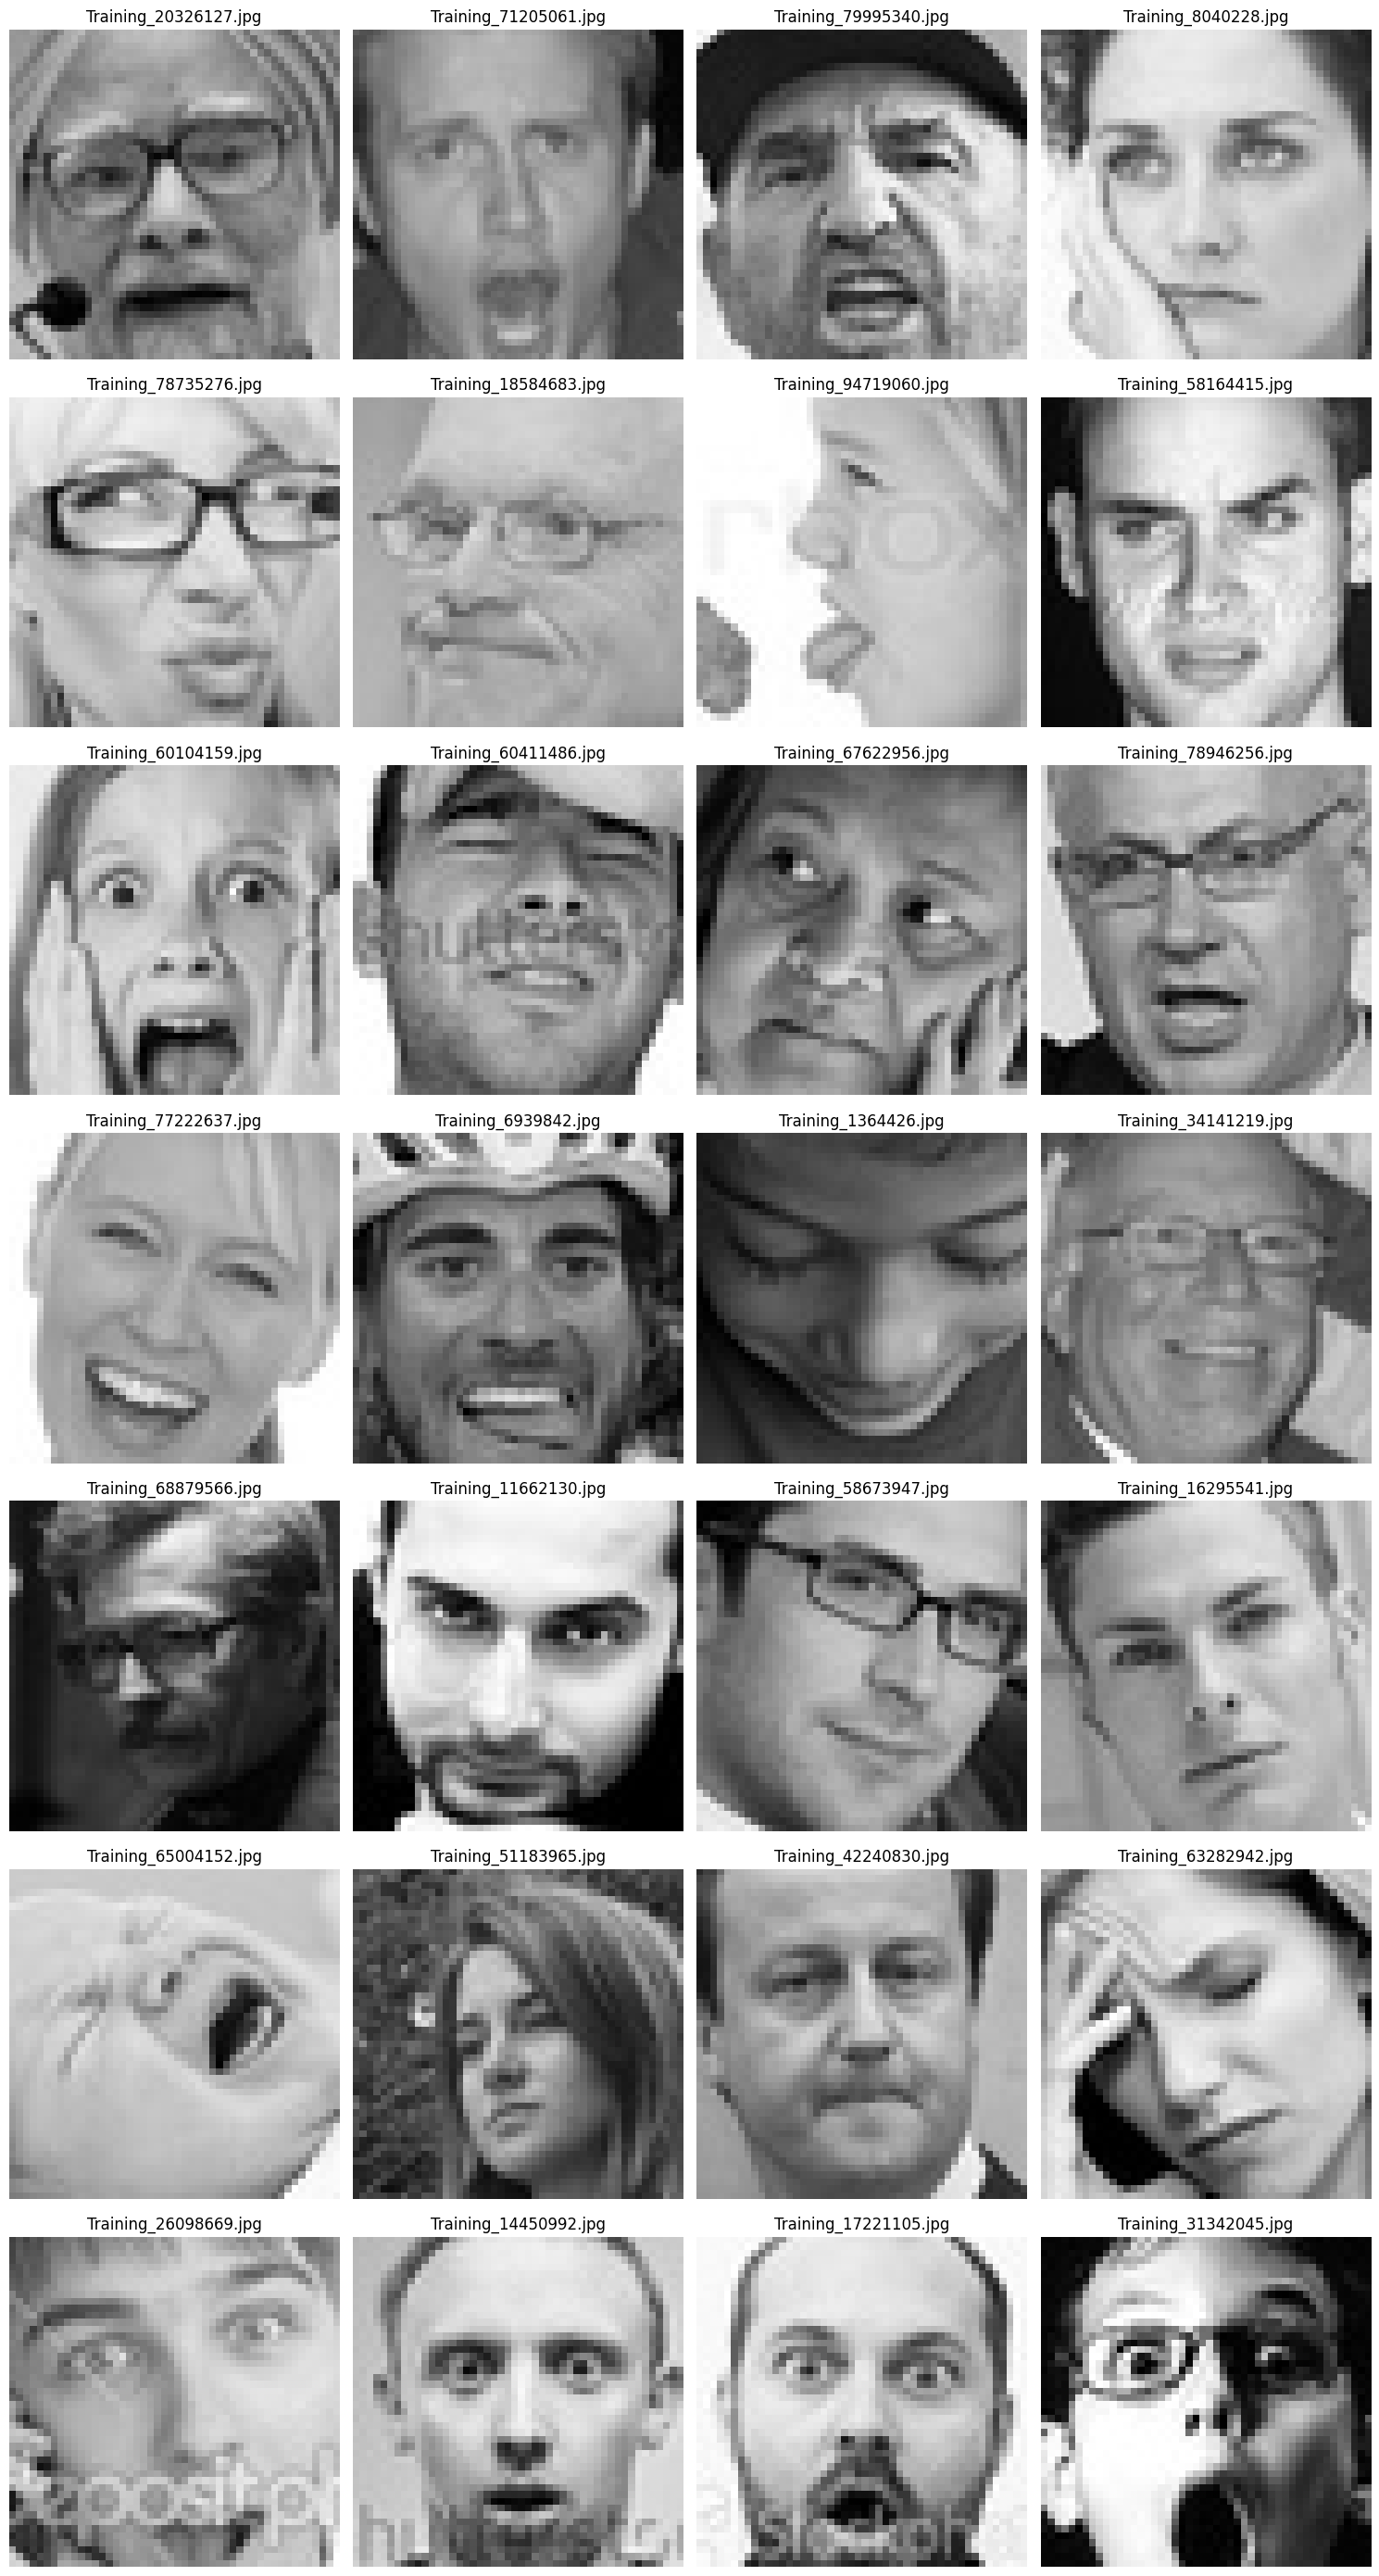

In [ ]:
# Anaylzing Images for Training
path_train = "/content/train"
image_directories_train = [path_train + "/angry/", path_train + "/disgust", path_train + "/fear",
                           path_train + "/happy", path_train + "/neutral", path_train + "/sad",
                           path_train + "/surprise"]
plot_images(image_directories_train)

#There are 3995 of 'angry', 436 of 'disgust', 4097 of 'fear', 7215 of 'happy', 4965 of 'neutral', 4830 of 'sad', and 3171 of 'surprise'

958
111
1024
1774
1233
1247
831


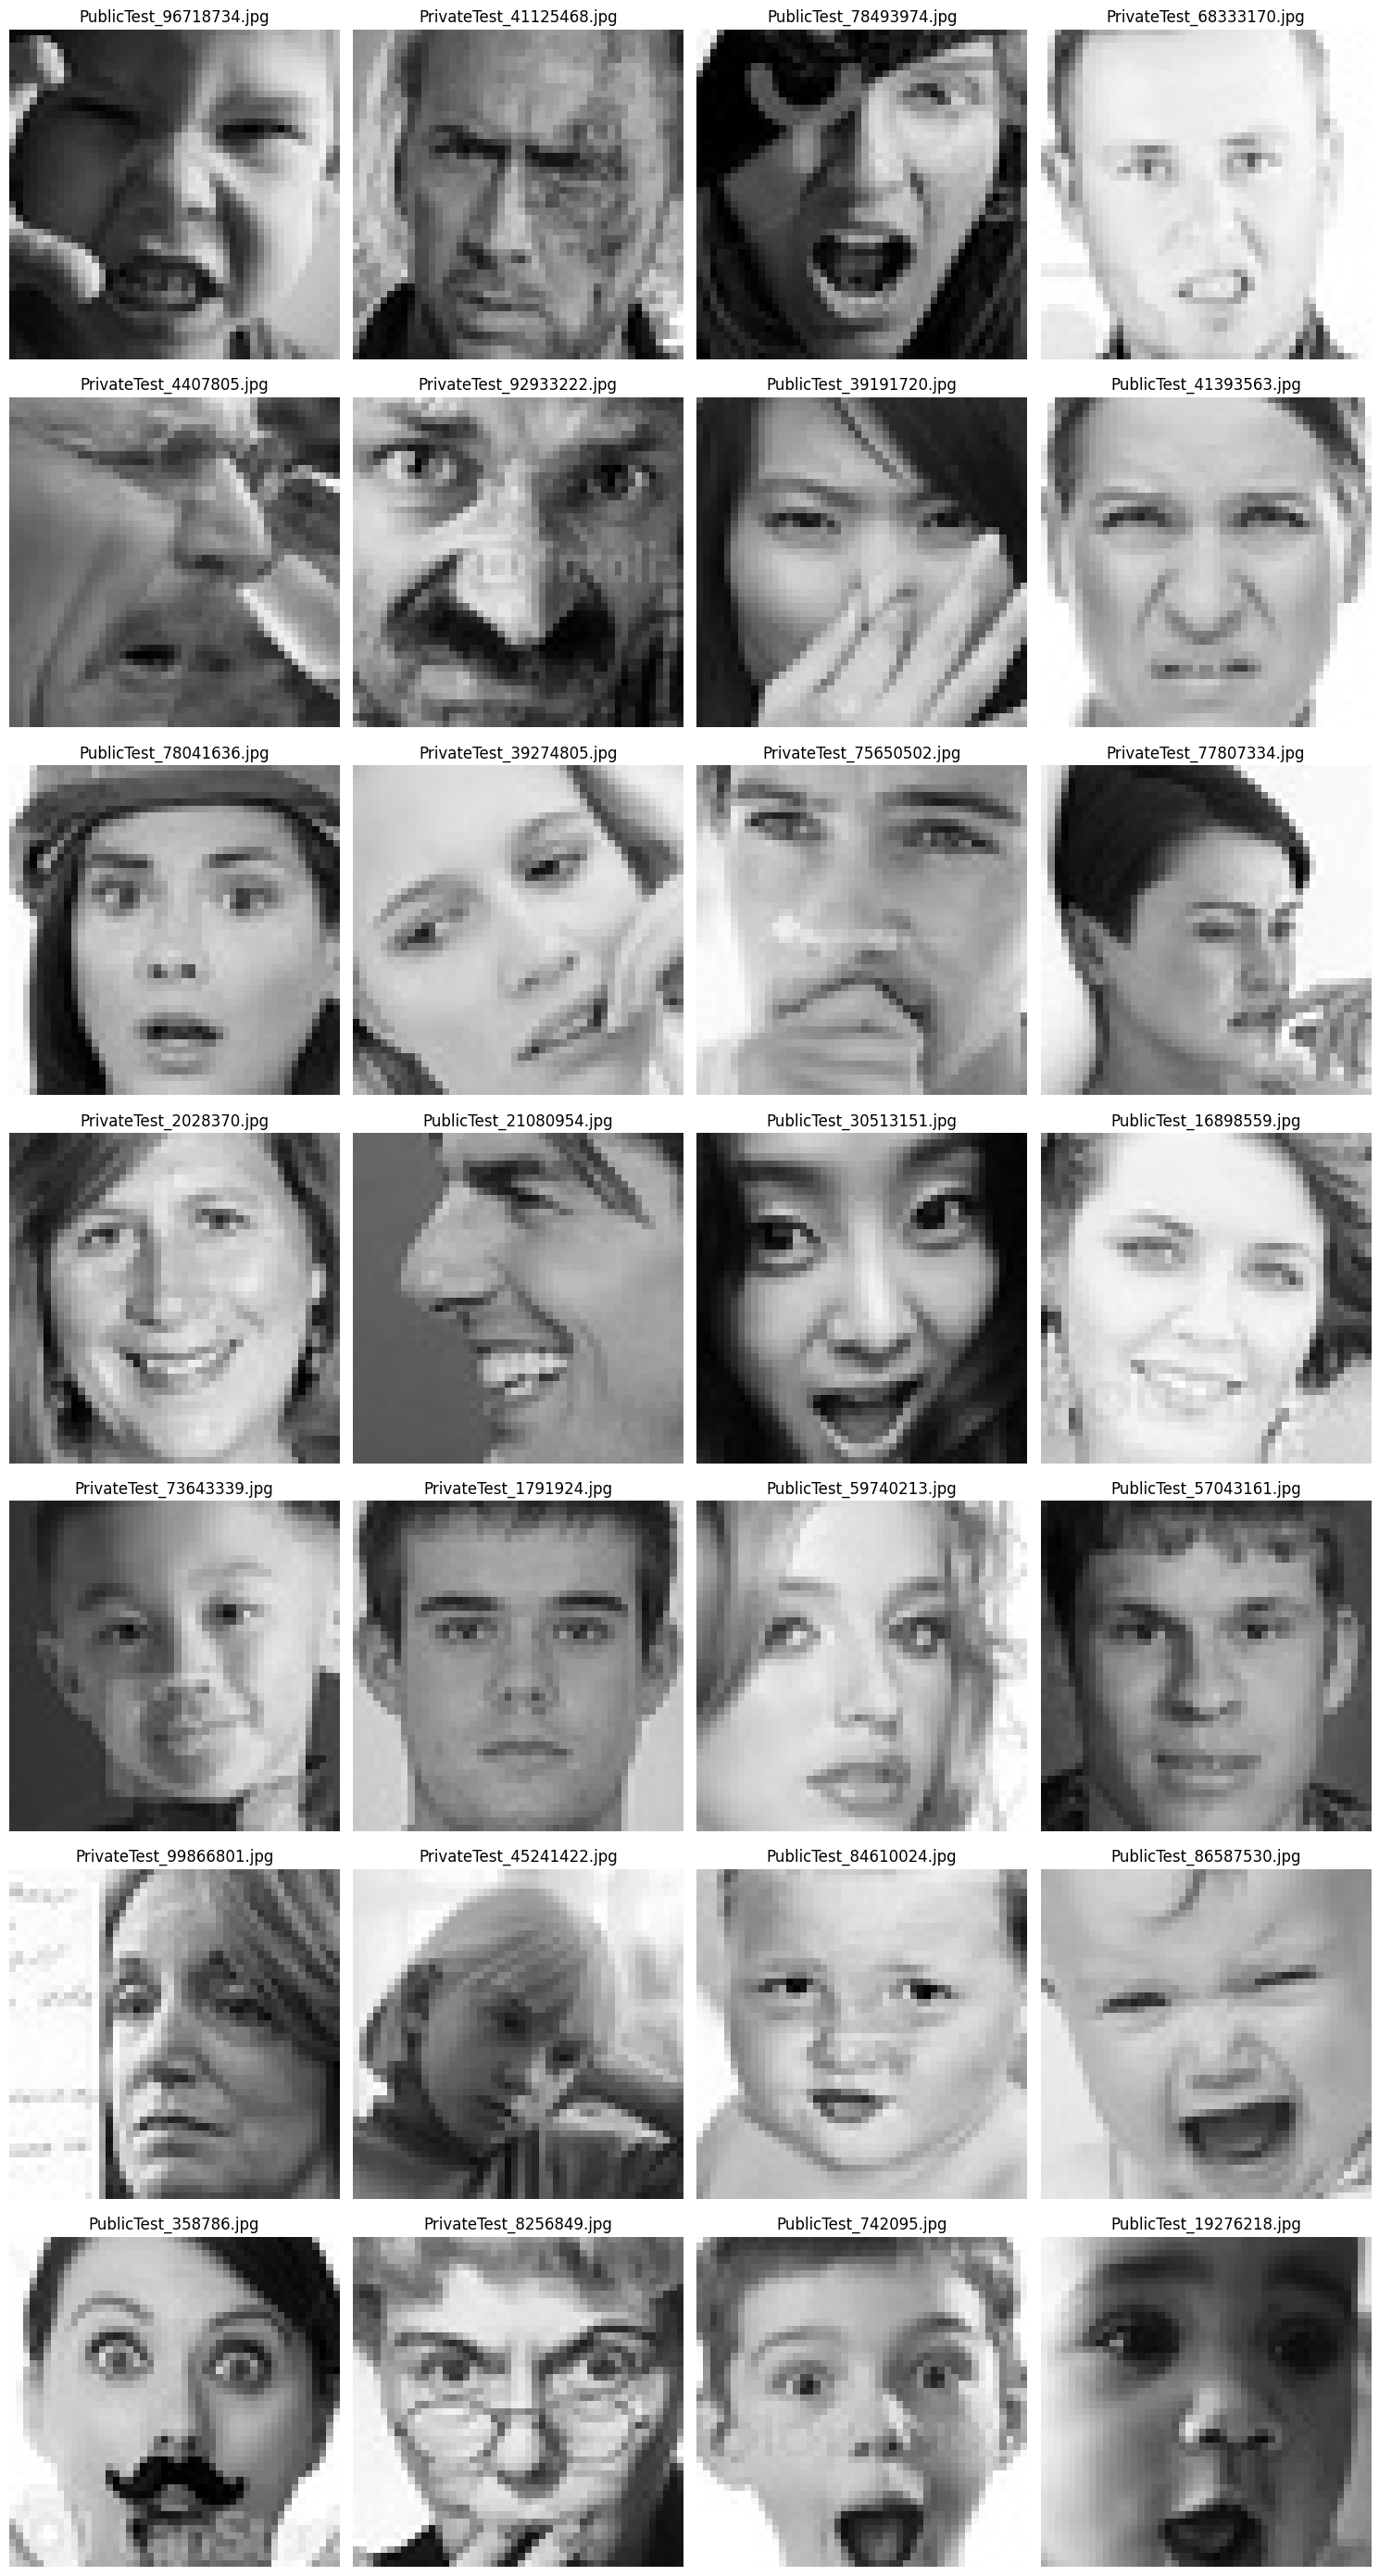

In [ ]:
# Anaylzing Images for Testing
path_test = "/content/test"
image_directories_test = [path_test + "/angry/", path_test + "/disgust", path_test + "/fear",
                           path_test + "/happy", path_test + "/neutral", path_test + "/sad",
                           path_test + "/surprise"]
plot_images(image_directories_test)

#There are 958 of 'angry', 111 of 'disgust', 1024 of 'fear', 1774 of 'happy', 1233 of 'neutral', 1247 of 'sad', and 831 of 'surprise'

In [ ]:
# Without preprocessing
train_images = tf.keras.utils.image_dataset_from_directory(
    path_train,
    image_size=(224, 224),
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 28709 files belonging to 7 classes.


In [ ]:
# Without preprocessing
test_images = tf.keras.utils.image_dataset_from_directory(
    path_test,
    image_size=(224, 224),
    color_mode='grayscale',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42,
)

Found 7178 files belonging to 7 classes.


In [ ]:
# Load EfficientNetB0 pre-trained model
pretrained_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
# Transfer learning - freezing layers of pre-trained model
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

In [ ]:
num_classes = len(set(train_images.class_names))

In [ ]:
# Adding in additional layers on top of pre-trained model
inputs = layers.Input(shape = (224,224,3), name='inputLayer')
pretrain_out = pretrained_model(inputs, training = False)
x = layers.Dense(128)(pretrain_out)
x = BatchNormalization()(x)

x = layers.Activation(activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256)(x)
x = BatchNormalization()(x)

x = layers.Activation(activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512)(x)
x = BatchNormalization()(x)

x = layers.Activation(activation="relu")(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(1024)(x)
x = BatchNormalization()(x)

x = layers.Activation(activation="relu")(x)
x = layers.Dropout(0.5)(x)

x = layers.Flatten()(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x)
model = Model(inputs=inputs, outputs=outputs)

# Adding 5 hidden layers to prevent too much overfitting from occurring - 4 dense and 1 flatten
# From preliminary experimentation, fewer layers and less complexity leads to more overfitting

In [ ]:
# Compile model with adam optimizer
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 dense (Dense)               (None, 7, 7, 128)         163968    
                                                                 
 batch_normalization (Batch  (None, 7, 7, 128)         512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 7, 7, 128)         0         
                                                                 
 dropout (Dropout)           (None, 7, 7, 128)         0     

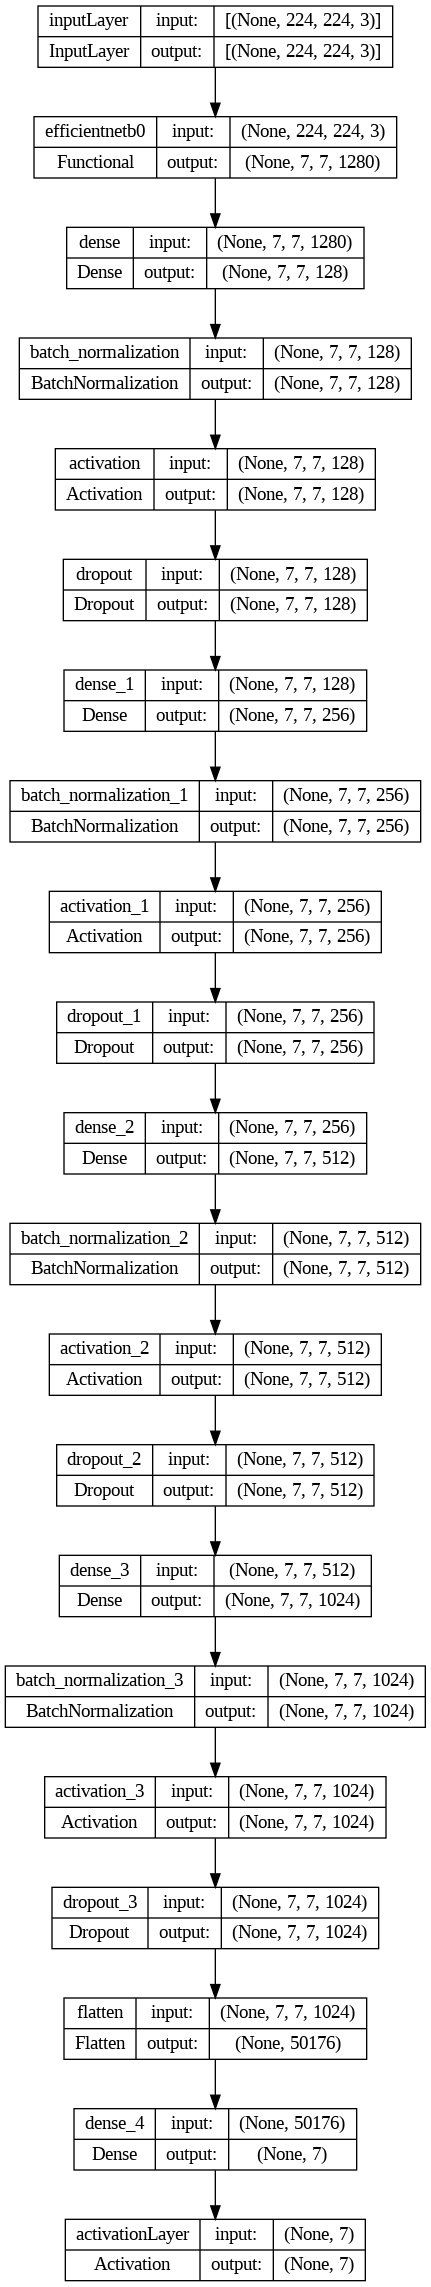

In [ ]:
tf.keras.utils.plot_model(model, "EmotionDetection.png", show_shapes=True)

In [ ]:
# Fitting model with 50 epochs & early stopping
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=test_images,
    validation_steps=len(test_images),
    epochs=50,
    callbacks=[
      tf.keras.callbacks.ModelCheckpoint("Moods.h5",save_best_only=True,save_weights_only=False)
      ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5),
    ]
)

# Due to early stopping, only 27 epochs ran

Epoch 1/50
898/898 [==============================] - ETA: 0s - loss: 2.1029 - accuracy: 0.3608

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


898/898 [==============================] - 68s 59ms/step - loss: 2.1029 - accuracy: 0.3608 - val_loss: 1.5114 - val_accuracy: 0.4894
Epoch 2/50
898/898 [==============================] - 49s 54ms/step - loss: 1.3856 - accuracy: 0.4894 - val_loss: 1.3130 - val_accuracy: 0.5249
Epoch 3/50
898/898 [==============================] - 49s 54ms/step - loss: 1.2765 - accuracy: 0.5282 - val_loss: 1.2054 - val_accuracy: 0.5524
Epoch 4/50
898/898 [==============================] - 49s 55ms/step - loss: 1.2151 - accuracy: 0.5483 - val_loss: 1.2387 - val_accuracy: 0.5433
Epoch 5/50
898/898 [==============================] - 48s 54ms/step - loss: 1.1562 - accuracy: 0.5675 - val_loss: 1.2352 - val_accuracy: 0.5468
Epoch 6/50
898/898 [==============================] - 52s 57ms/step - loss: 1.1268 - accuracy: 0.5798 - val_loss: 1.1664 - val_accuracy: 0.5687
Epoch 7/50
898/898 [==============================] - 48s 54ms/step - loss: 1.0914 - accuracy: 0.5932 - val_loss: 1.1581 - val_accuracy: 0.5719
Epo

In [ ]:
# Test accuracy
test_loss, test_accuracy = model.evaluate(test_images)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# In this case, since validation used the test dataset, the validation and testing accuracy and loss are the same

225/225 [==============================] - 9s 41ms/step - loss: 1.2492 - accuracy: 0.6070
Test Loss: 1.2492197751998901
Test Accuracy: 0.6069936156272888


In [ ]:
# Including graphical representation to understand Training vs Validation Accuracy & Training vs Validation Loss
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

<ipython-input-19-533555d13005>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


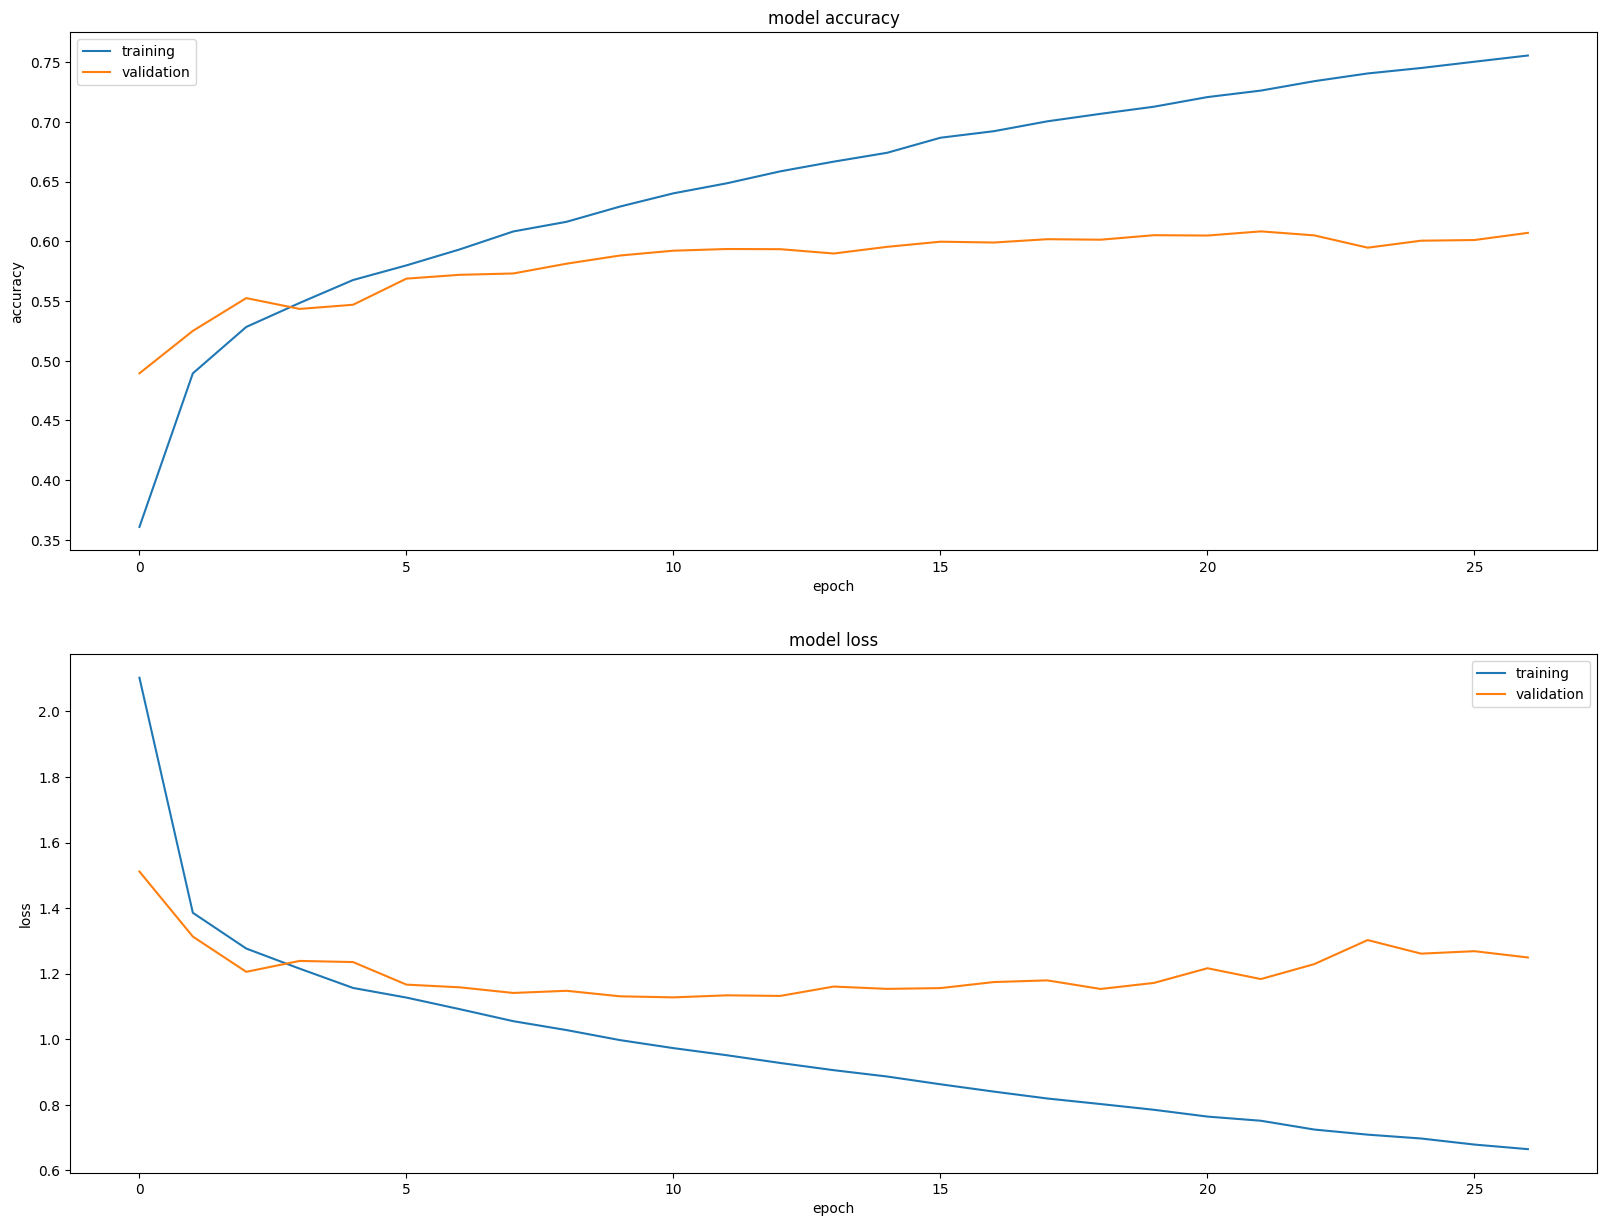

In [ ]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
# The model selected achieved 60.7% validation accuracy and 1.2492 validation loss.
# Near the end of training, the training accuracy grew noticeably higher vs validation accuracy.
# For next steps, we could experiment with more layers and alternative hyperparameters to address this overfitting.

In [ ]:
# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

test_images_for_labels = tf.keras.utils.image_dataset_from_directory(
    path_test,
    image_size=(224, 224),
    color_mode='grayscale',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    shuffle=False,
    seed=42,
)

test_labels = []
for images, labels in test_images_for_labels:
    test_labels.extend(labels.numpy())

pred1 = model.predict(test_images)
pred1 = np.argmax(pred1, axis=1)

Found 7178 files belonging to 7 classes.
225/225 [==============================] - 12s 37ms/step


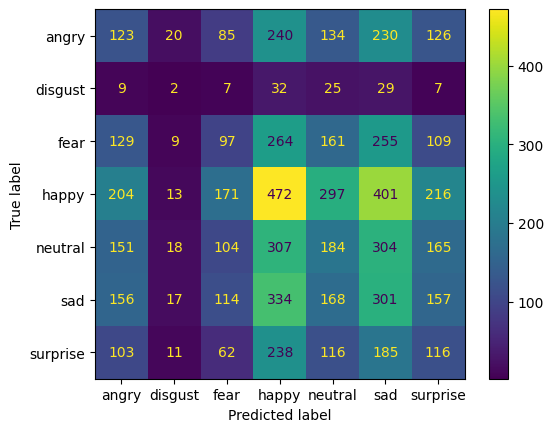

In [ ]:
cm = confusion_matrix(test_labels, pred1)
class_names = sorted(os.listdir(path_test))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()

In [ ]:
# Within the confusion matrix we can see that while the expression of “happy” most often gets correctly classified,
# other emotions tend to get confused for it. Additionally, it is very hard for the model to accurately predict the emotion ‘disgust’.

In [ ]:
# The over-prediction of “happy” may suggest that in addition to the unbalanced training data the facial nuances
# that exist in other emotions are more difficult to classify. This may pose difficulties when leveraging this capability
# in real-world applications. As “happy” had the largest training set, this is also indicative of data availability for future training,
# as leveraging publicly available image data often has a positive bias.

In [ ]:
# Including a t-SNE plot
from sklearn.manifold import TSNE
x_train = model.predict(train_images)
x_test = model.predict(test_images)

225/225 [==============================] - 8s 37ms/step


In [ ]:
tsne = TSNE(n_components=2, random_state=42)
x_train_tsne = tsne.fit_transform(x_train.reshape(x_train.shape[0], -1))
x_test_tsne = tsne.fit_transform(x_test.reshape(x_test.shape[0], -1))

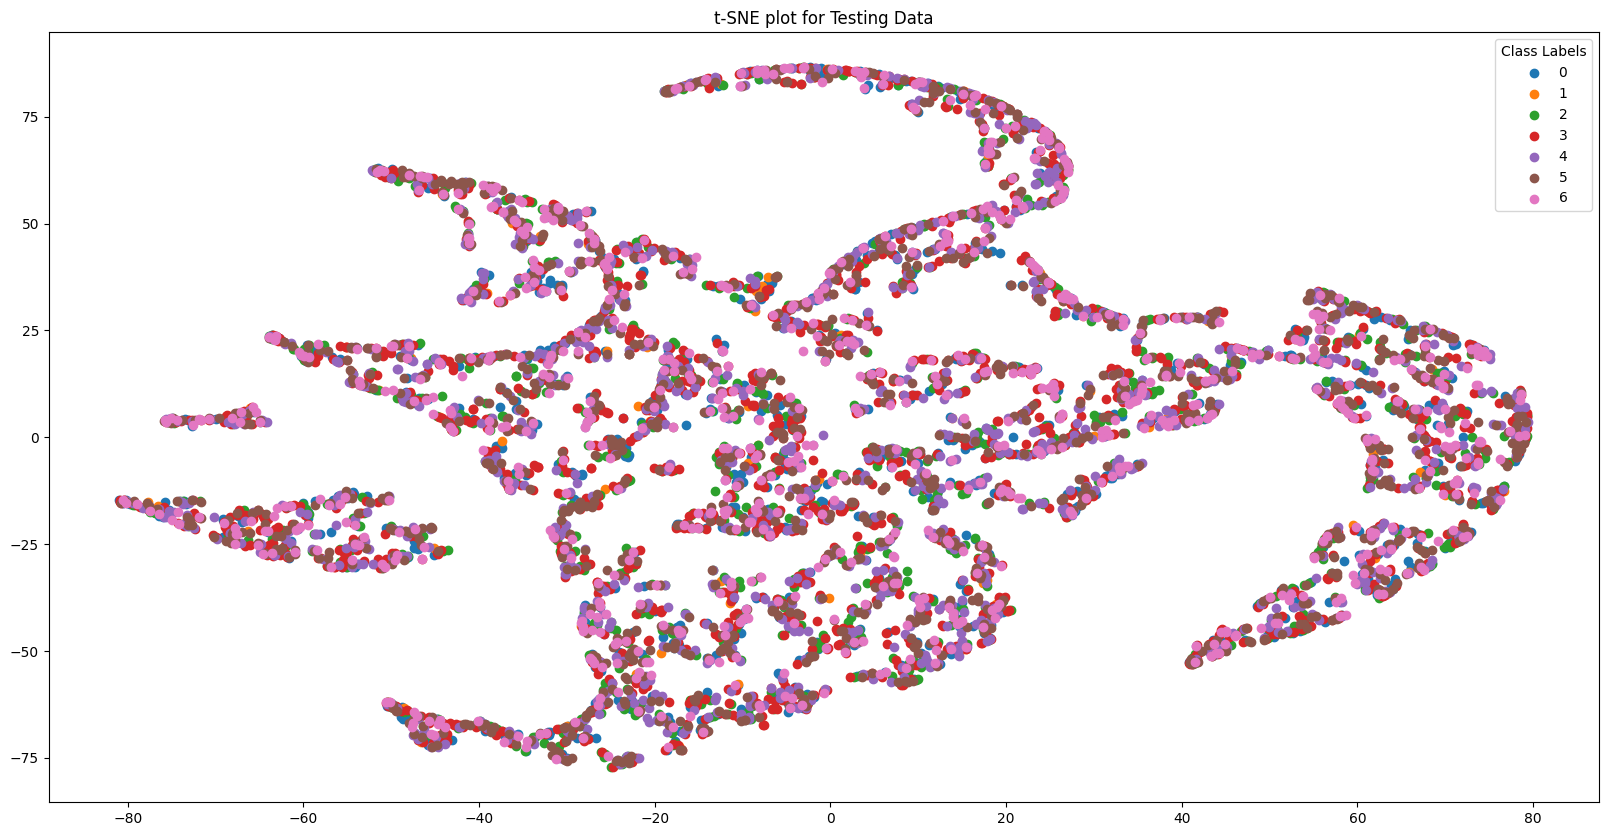

In [ ]:
plt.figure(figsize=(20, 10))
plt.title('t-SNE plot for Testing Data')

test_labels = []
for images, labels in test_images:
    test_labels.extend(np.argmax(labels.numpy(), axis=1))

unique_labels = np.unique(test_labels)

for label in unique_labels:
    indices = np.array(test_labels) == label
    plt.scatter(x_test_tsne[indices, 0], x_test_tsne[indices, 1], label=str(label))

plt.legend(title='Class Labels', loc='upper right')
plt.show()

In [ ]:
# The t-SNE plot has quite a bit of overlap and does not show much class separation

In [ ]:
# Print classification report
from sklearn.metrics import classification_report
import os
class_names = sorted(os.listdir(path_test))
class_report = classification_report(test_labels, pred1, target_names=class_names)
print(class_report)

              precision    recall  f1-score   support

       angry       0.14      0.13      0.13       958
     disgust       0.01      0.01      0.01       111
        fear       0.13      0.08      0.10      1024
       happy       0.22      0.23      0.23      1774
     neutral       0.17      0.15      0.16      1233
         sad       0.18      0.25      0.21      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [ ]:
# Similar to the Confusion Matrix, the Classification report indicates that 'happy' is more likely to be predicted correctly and 'disgust' much less so

In [ ]:
model.save('emotiondetection.keras')

In [ ]:
model.save('emotiondetection.pkl')

In [ ]:
# Print classification report
from sklearn.metrics import classification_report
import os
class_names = sorted(os.listdir(path_test))
class_report = classification_report(test_labels, pred1, target_names=class_names)
print(class_report)

              precision    recall  f1-score   support

       angry       0.14      0.13      0.13       958
     disgust       0.01      0.01      0.01       111
        fear       0.13      0.08      0.10      1024
       happy       0.22      0.23      0.23      1774
     neutral       0.17      0.15      0.16      1233
         sad       0.18      0.25      0.21      1247
    surprise       0.12      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [ ]:
# Similar to the Confusion Matrix, the Classification report indicates that 'happy' is more likely to be predicted correctly and 'disgust' much less so

In [ ]:
model.save('emotiondetection.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Code for Streamlit App

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
from keras.models import load_model
model = load_model('/content/drive/My Drive/emotiondetection.h5')

Mounted at /content/drive


The dtype policy mixed_float16 may run slowly because this machine does not have a GPU. Only Nvidia GPUs with compute capability of at least 7.0 run quickly with mixed_float16.
If you will use compatible GPU(s) not attached to this host, e.g. by running a multi-worker model, you can ignore this warning. This message will only be logged once


In [ ]:
!pip install -q streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 86.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00


In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

In [ ]:
%%writefile app.py

import streamlit as st
from tensorflow.keras.preprocessing import image as tf_image
from tensorflow.keras.applications.efficientnet import preprocess_input
import json
import time
from PIL import Image
import numpy as np
import pandas as pd
import cv2
import math
import io
from urllib.request import urlopen
from keras.models import load_model
model = load_model('/content/drive/My Drive/emotiondetection.h5')


st.set_page_config(layout='wide')


def add_bg_from_url():
    st.markdown(
         f"""
         <style>
         .stApp {{
             background-image: url("https://raw.githubusercontent.com/adhok/SeeFood/main/luxury-ornamental-mandala-design-background_1159-6794.jpg");
             background-attachment: fixed;
             background-size: cover
         }}
         </style>
         """,
         unsafe_allow_html=True
     )

add_bg_from_url()


st.sidebar.write("""
                 **Unmasking Authentic Reactions:**

                 Leveraging Facial Emotion Recognition to Reveal Genuine Gastronomic Sentiments Amidst Normative Social Influence
                 """)

st.sidebar.write("""
                 **Northwestern University Computer Vision Final Project**

                    Archit Argawal

                    Winnie Wu

                    Danica Bellchambers

                    Faris Raza
                 """)
# Put data
# details

model=model
class_names= ["angry", "disgust", "fear","happy", "neutral", "sad","surprise"]

# Load pre-trained model
@st.cache_resource
# def load_model():
#     model = tf.keras.applications.MobileNetV2(weights='imagenet')
#     return model

@st.cache_resource

def load_and_preprocess_image(image_path):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    img_array = tf_image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

def makes_preditions(uploaded_file):
    preprocessed_image = load_and_preprocess_image(uploaded_file)
    predictions = model.predict(preprocessed_image)
    decoded_predictions = predictions[0]
    return decoded_predictions

def decode_and_print(decoded_predictions, class_names):
    df = pd.DataFrame({'Emotion': class_names, 'Similarity Score': decoded_predictions})
    df['Similarity Score'] = df['Similarity Score'].map('{:.2%}'.format)
    st.dataframe(df)
    return(df)

def load_analyse_video(videoFile):
    video_output = []
    cap = cv2.VideoCapture(videoFile)
    frameRate = cap.get(5) #frame rate
    x=1
    while(cap.isOpened()):
        frameId = cap.get(1) #current frame number
        ret, frame = cap.read()
        if (ret != True):
            break
        if (frameId % math.floor(frameRate) == 0):
            img_array = tf_image.img_to_array(frame)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            predictions = model.predict(img_array)
            decoded_predictions = decode_predictions(predictions, top=1)[0]
            for i, (imagenet_id, label, score) in enumerate(decoded_predictions):
                video_output.append([label,score*100])
    cap.release()
    return video_output

def video_analysis(video_output):
    df = pd.DataFrame(video_output,columns=['Prediction','Score'])
    df = df.groupby('Prediction').count()
    return df


# VIDEO_URL = "https://www.youtube.com/watch?v=ZyMEXBKuGKY"
# st.video(VIDEO_URL)



#### BELOW IS APP ####

st.title("Unmasking Authentic Reactions in Dining Establishments")
#st.title("Test")

image_col, middle_col, output_col = st.columns([4,1,4])

with image_col:
    st.write('Upload a photo to analyse')
    uploaded_file = st.file_uploader("Choose a file")

    if uploaded_file != None:

        if uploaded_file.type == 'image/jpeg':
            image = Image.open(uploaded_file)
            img_array = np.array(image)
            st.image(img_array, caption="Customer coming out of restaurant", use_column_width=True)

        # elif uploaded_file.type == 'video/mp4':
        #     st.video(uploaded_file)
        #     g = io.BytesIO(uploaded_file.read())  ## BytesIO Object
        #     temporary_location = "testout_simple.mp4"

        #     with open(temporary_location, 'wb') as out:  ## Open temporary file as bytes
        #         out.write(g.read())  ## Read bytes into file

        else:
            st.write('Please upload only video or image for analysis. Other file types are not accepted.')

with middle_col:
    st.write('')

with output_col:
    st.write('Run predictions to classify image')
    st.header('')
    preds = st.slider("Select number of predictions to output",1,len(class_names),7)

    if st.button('Run predictions'):
        with st.spinner('Running Predictions'):
            if uploaded_file.type == 'image/jpeg':
              st.write("Image processing")
              # decoded_predictions = makes_preditions(uploaded_file,preds)
              st.write(f'The top {preds} predictions for classification are:')
              decode_and_print(weights(),class_names)
              st.write(':red[**Change the prediction number to show more/less options.]')

            # elif uploaded_file.type == 'video/mp4':
            #     video_output = load_analyse_video(temporary_location)
            #     df_video = video_analysis(video_output)
            #     st.dataframe(df_video)

Writing app.py


In [ ]:
!npm install localtunnel

npm WARN saveError ENOENT: no such file or directory, open '/content/package.json'
npm notice created a lockfile as package-lock.json. You should commit this file.
npm WARN enoent ENOENT: no such file or directory, open '/content/package.json'
npm WARN content No description
npm WARN content No repository field.
npm WARN content No README data
npm WARN content No license field.

+ localtunnel@2.0.2
added 22 packages from 22 contributors and audited 22 packages in 3.659s

3 packages are looking for funding
  run `npm fund` for details

found 1 moderate severity vulnerability
  run `npm audit fix` to fix them, or `npm audit` for details


In [ ]:
## password to strealit app is the IP printed here
!streamlit run app.py &> /content/logs.txt & npx localtunnel --port 8501 & curl ipv4.icanhazip.com

35.243.171.68
npx: installed 22 in 3.018s
your url is: https://ten-icons-notice.loca.lt
